# Signal statistics for beamformer and correlator

Author: Eric Kooistra, Aug - Dec 2022

Purpose: Model the SNR of a beamformer and a correlator

Description:
* In coherent processing multiple signals are processed synchronously, so by using voltages to maintain their phase (time) relation. In incoherent procesing the multiple signals are processed asynchronously, so there time (phase) relation is random or their phase relation is lost by processing powers.
* SNR: This model shows two different SNR measures [1]. One regarding the 'coherent' SNR of the coherent signal versus the incoherent signal (e.g. in a voltage beamformer, in a correlator) that indicates the strength of the coherent signal with respect to the incoherent noise, and one regarding the 'incoherent' SNR of the power measurement itself, that indicates the accuracy if the measured power (e.g. in power statistics, in a powers beamformer). The 'coherent' SNR makes use of phase information of the input voltage signals. The 'incoherent' SNR is based on input powers, so the input phase information is lost, and therefore the 'incoherent' SNR can only improve the accuracy of the mean power measurement, it cannot improve (distinguish) between coherent signal and incoherent noise.
* Coherent summator (sums voltages, e.g. voltage beamformer): The 'coherent' SNR of coherent input versus the incoherent input improves by the number of inputs N.
* Incoherent summator (sums powers, e.g. auto power statistics, power beamformer): The 'coherent' SNR of coherent input versus incoherent input does not improve, because the coherent phase information is lost in the powers. However, the accuracy of mean power measurement, so the 'incoherent' SNR, does improve by factor sqrt(N), because the std of the mean power measurement reduces by sqrt(N).
* Correlator: The 'coherent' SNR of coherent input versus the incoherent input improves by sqrt(N) for integration over N cross powers in time. The mean correlation of the coherent input is constant and non-zero. The mean correlation of the incoherent input is zero. The power of the mean correlation of the incoherent input reduces by N, so the std of the mean correlation of the incoherent input reduces by sqrt(N). For example, if the input SNR of the input signal is -20 dB (i.e. sigma_coh / sigma_sys = 0.1), then it takes integration over N = 10000 cross powers in time to improve the SNR of the correlator output by a factor 100 = +20 dB to 0 dB.

Remarks:
* The number of samples N can be increased in two ways. One is to measure longer in time (integration) or in space (beamforming). The other is to increase the bandwidth of the signal. Increasing the bandwidth implies more samples per interval are needed. Therefore the number of samples N is proportional to the bandwidth * time product. A time T interval for a signal with bandwidth BW contains approximately N = 2 * BW * T independent samples, where 2 is the Nyquist factor 2 for sampling the BW without aliasing. Hence N values can represent samples for a certain combination of bandwidth and time. To double N, either double the time or double the bandwidth: Time: . . . . --> . . . . . . . .,   Bandwidth: . . . . --> ........
* Summing powers from N inputs (like in an incoherent array beamformer = IAB) or summing N powers in time from 1 input (like in auto power statistics of subbands = SST or of beamlets = BST) is equivalent. However for events that last shorter than the BST integration time, the IAB does have a benefit over BST, because the IAB can use an N times shorter integration time.
* The field of view of a voltage beamformer reduces by a factor N, to accomodate for the 'coherent' SNR improvement. The field of view of the incoherent array power beam (IAB) is the same as the field of view of one input, because the 'coherent' SNR of the IAB does not improve.
* As a side effect the model for auto power SNR improvement also shows that the accuracy of the power of the generated noise itself improves by N, so 10 dB / decade. So the difference of actual generator noise power - the requested generator noise power will decrease with N. 

Usage:
* On command line start: > jupyter notebook
* In browser open the ipynb and run it

References:

1. Understanding digital signal processing, R.G. Lyons

In [2]:
import numpy as np
import matplotlib.pyplot as plt

dpi = 254  # 10 dots per mm

## 1 Statistics basics:

Signal statistics

* dc = mean  # direct current, average value of a signal
* sigma = std = sqrt(var) # standard deviation, measure for fluctuating portion of a signal
* var = std**2  # variance, power of the fluctuating portion of a signal
* power = var + mean**2
* rms = sqrt(power) = sqrt(var + mean**2)

If mean = 0 then var = power and std = rms.

For a complex signal (like subbands and beamlets), assume mean complex = 0 so rms = std and power = var (= std^2):

* power complex = power real + power imag = (std real)^2 + (std imag)^2
* power real = power imag = power complex / 2
* std real = std imag = std complex / sqrt(2)
* std complex = sqrt(power complex)
* ampl real = ampl imag = std complex = std real * sqrt(2) = std imag * sqrt(2)

Coherent and incoherent signals. With S signals, the std of their sum signal:

* increases by S for coherent signals
* increases by sqrt(S) for incoherent signals

Coherent averaging by summing voltage signals improves the 'coherent' SNR of a signal by a factor N^2 / N = N, because the coherent signal power increases by a factor N^2, while the incoherent noise adds as powers, so the noise power increases by a factor N.

Incoherent averaging by summing power signals does not improve the 'coherent' SNR, because the phase information of the signal is lost in the powers. Incoherent averaging does reduce the std of the signal power estimate by a factor sqrt(N), so incoherent averaging does inprove the 'incoherent' SNR, because it makes the signal power measurement more accurate.

In [3]:
def rms(arr):
    """Root mean square of values in arr
    
    rms = sqrt(mean powers) = sqrt(std**2 + mean**2)
    
    The rms() also works for complex input thanks to using np.abs().
    """
    return np.sqrt(np.mean(np.abs(arr)**2.0))

In [4]:
N_samples = 10000
sigma = 0.5
var = sigma**2
dc = -0.2

# Signal input voltages
si = np.random.randn(N_samples)
si *= sigma / np.std(si)  # apply requested sigma
si += dc  # add offset

print(f"mean(si) = {np.mean(si):.6f}, expected {dc}")
print(f"std(si) = {np.std(si):.6f}, expected {sigma}")
print(f"rms(si) = {rms(si):.6f}, expected {np.sqrt(var + dc**2):.6f}")      

mean(si) = -0.202234, expected -0.2
std(si) = 0.500000, expected 0.5
rms(si) = 0.539350, expected 0.538516


## 2 Summator

Two types:

1. Coherent summation in voltage beamformer (e.g. digital BF in LOFAR2 Station, tied array beamformer = TAB in ARTS)
2. Incoherent summation in power statistics (e.g. SST, BST), power beamformer (e.g. IAB in ARTS)

### 2.1 Coherent summation (voltages beamformer)

Two signal input types:
    
1. Coherent signals, add up as voltages
2. Incoherent signal, add up as powers

In the voltage beamformer the sky signal in the beamlet direction adds coherently and the sky
signals from other directions and the signals from the receivers noise add incoherently.

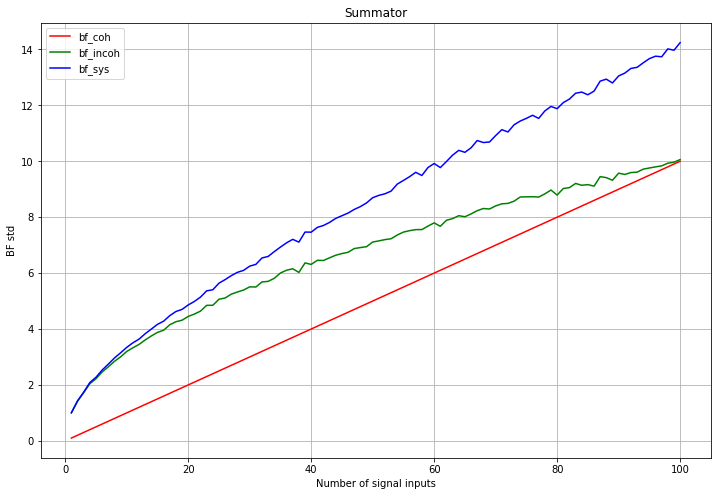

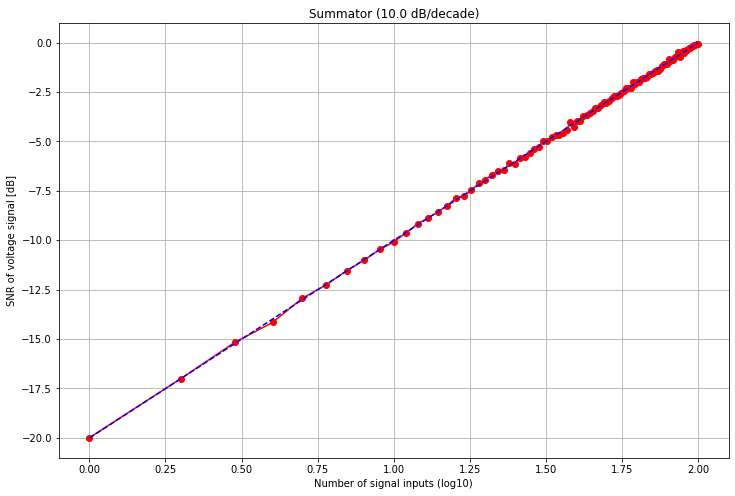

In [5]:
# Signal inputs
# . Warning: do use not too high values for N_samples and S_max to avoid too long compute time.
N_samples = 10000  # >= 3
S_max = 100
S_arr = np.arange(1, S_max + 1)
S_arr_log = np.log10(S_arr)

sigma_coh = 0.1
sigma_incoh = 1.0

si_coh = np.random.randn(N_samples)
si_coh *= sigma_coh / np.std(si_coh)

# Voltage beamformer sum(S)
bf_coh_std_arr = []
bf_incoh_std_arr = []
bf_sys_std_arr = []
coh_SNR_dB_arr = []
for S in S_arr:
    # The coh signal in the beamlet direction adds coherently for all signal inputs
    bf_coh = S * si_coh
    bf_coh_std = np.std(bf_coh)
    bf_coh_std_arr.append(bf_coh_std)
    
    # The incoh signals from other directions and from the receivers noise add incoherently
    bf_incoh = np.zeros(N_samples)
    for si in range(1, S + 1):
        si_incoh = np.random.randn(N_samples)
        si_incoh *= sigma_incoh / np.std(si_incoh)
        bf_incoh += si_incoh
    bf_incoh_std = np.std(bf_incoh)
    bf_incoh_std_arr.append(bf_incoh_std)
        
    # Total BF output
    bf_sys_std = np.std(bf_coh + bf_incoh)
    bf_sys_std_arr.append(bf_sys_std)
    
    # SNR of the coherent sum
    coh_SNR_dB = 20 * np.log10(bf_coh_std / bf_incoh_std)
    coh_SNR_dB_arr.append(coh_SNR_dB)

plt.figure(figsize=(12, 8))
plt.plot(S_arr, bf_coh_std_arr, 'r', S_arr, bf_incoh_std_arr, 'g', S_arr, bf_sys_std_arr, 'b')
plt.title("Summator")
plt.xlabel("Number of signal inputs")
plt.ylabel("BF std")
plt.legend(['bf_coh', 'bf_incoh', 'bf_sys'])
plt.grid()
plt.savefig('plots/signal_statistics_summator_std.jpg', dpi=dpi)

plt.figure(figsize=(12, 8))
fit_coef = np.polyfit(S_arr_log, coh_SNR_dB_arr, 1)
fit_p = np.poly1d(fit_coef)
fit_line = fit_p(S_arr_log)
plt.plot(S_arr_log, coh_SNR_dB_arr, 'r-o', S_arr_log, fit_line, 'b--')
plt.title("Summator (%3.1f dB/decade)" % fit_p[1])
plt.xlabel("Number of signal inputs (log10)")
plt.ylabel("SNR of voltage signal [dB]")
plt.grid()
plt.savefig('plots/signal_statistics_summator_snr.jpg', dpi=dpi)

**Conclusion:**
The voltage beamformer improves the 'coherent' SNR of the beamlet signal by factor S, because the coherent signal power increases by S^2 while the incoherent noise power increases by S. For very weak astronomical signals this 'coherent' SNR improvement is not enough to make them appear above the system noise, so then additional voltage beamforming is needed or integration in time using a correlator is needed.

### 2.2 Incoherent summation (powers beamformer)


Incoherent summation of powers from S inputs is equivalent to incoherent summation of S powers in time from a single input. Incoherent summation does not improve the 'coherent' SNR of the signal, but it does improve the accuracy of the power measurement by a factor S. Hence instead of measuring with one dish for S intervals it is equivalent to sum the powers of S dishes for 1 interval. Hence the field of view of the summed incoherent array power beam (IAB) is the same as the field of view of one signal input.

## 3 Correlator


### 3.1 Auto powers

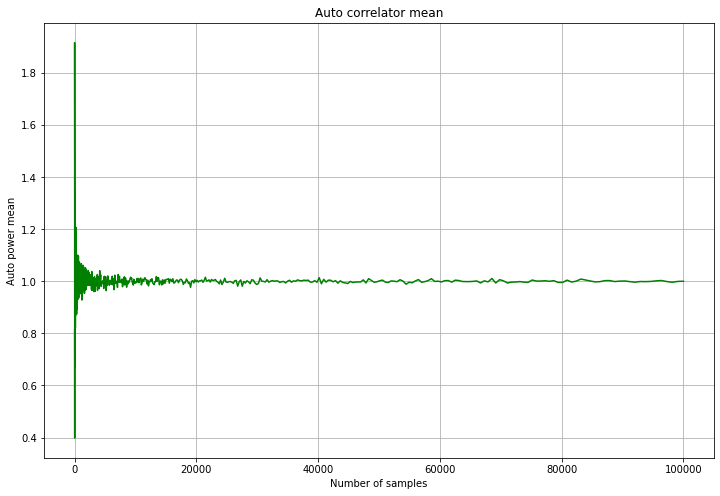

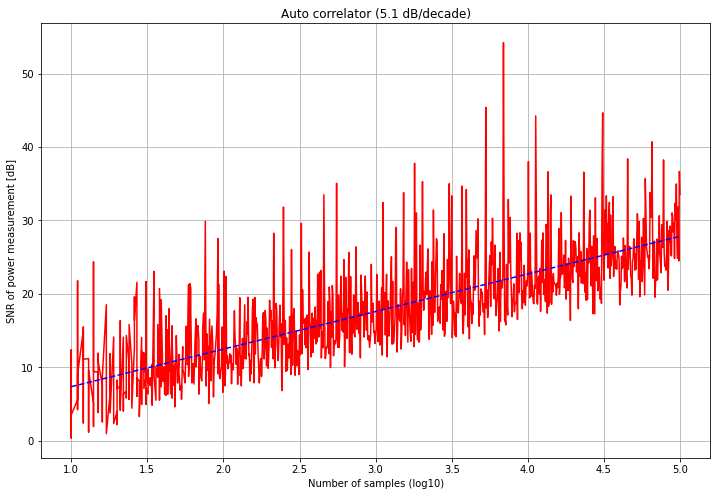

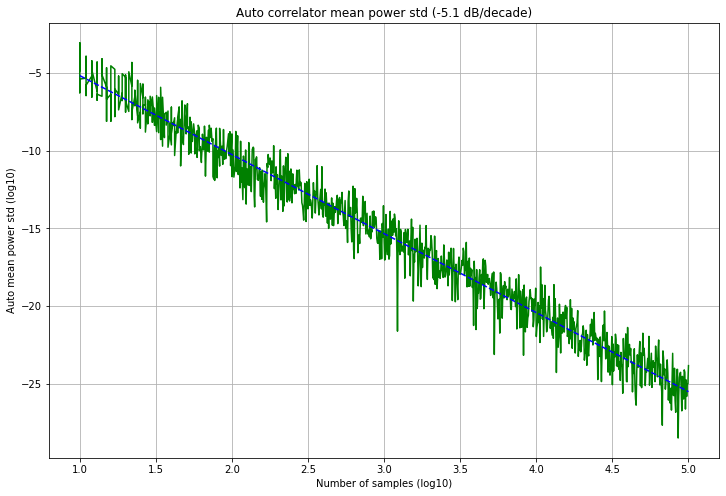

In [6]:
# Number of samples N_samples in time for input A, try N_samples in N_samples_arr
N_steps = 1000

N_min = 10
N_max = 100000
n_incr = (N_max / N_min)**(1 / N_steps)
N_samples_arr = []
for s in range(N_steps + 1):
    n = int(N_min * n_incr**s)
    N_samples_arr.append(n)
    
N_samples_arr_log = np.log10(N_samples_arr)

# External signal
sigma = 1.0
expected_pow_mean = sigma**2

len_factor = 2

# Auto correlator mean(A * A)
auto_mean_arr = []
auto_std_arr = []
auto_mean_SNR_arr = []
auto_mean_SNR_dB_arr = []
for N_samples in N_samples_arr:
    # External volts signal with expected_pow_mean over more than N_max samples
    # . len_factor = 1 yields SNR improving 10 dB/decade, which is not what is intended.
    #   In fact using len_factor = 1 measures the numpy random generator itself, so the
    #   accuracy of pow_mean of the generated sequence improves linearly with N.
    # . len_factor >~ 2 is sufficient to make that the sA snapshot of volts measures
    #   the expected_pow_mean of volts. The SNR improvement is now 5 dB/decade,
    #   which agrees with that the expected SNR of auto power statistics improves
    #   with sqrt(N).
    # The volts signal is recreated in each loop, instead of reusing a volts signal
    # outside the loop, to have independent results per loop.
    volts = np.random.randn(int(N_samples * len_factor))
    #volts = np.random.randn(int(N_max * len_factor))  # yields same result, but takes longer
    volts *= sigma / np.std(volts)  # force volts to have expected_pow_mean
    
    # Measure signal input A snapshot from volts
    sA = volts[0:N_samples-1]
    pA = sA * sA   # input power values

    # Auto correlate A
    # . the auto_mean is the mean power
    auto_mean = np.mean(pA)
    auto_mean_arr.append(auto_mean)
    # . the np.std(pA) is not useful, because for powers all info is already in the auto_mean
    auto_std = np.std(pA)
    auto_std_arr.append(auto_std)

    # Accuracy of the power measurement
    auto_mean_SNR = 1 / np.abs(auto_mean - expected_pow_mean)
    auto_mean_SNR_dB = 10 * np.log10(auto_mean_SNR)
    auto_mean_SNR_arr.append(auto_mean_SNR)
    auto_mean_SNR_dB_arr.append(auto_mean_SNR_dB)
    
    #print(f"{N_samples}, {auto_mean:9.6f}, {auto_mean_SNR_dB:.0f}")
    
# Determine accuracy of the auto_mean by using N_measure to measure auto_mean_std using std()
# instead of using auto_mean_SNR = auto_mean - expected_pow_mean
N_measure = 10

auto_mean_std_log10_arr = []
for N_samples in N_samples_arr:
    am_arr = []
    for R in range(N_measure):
        volts = np.random.randn(int(N_samples * len_factor))
        #volts = np.random.randn(int(N_max * len_factor))  # yields same result, but takes longer
        volts *= sigma / np.std(volts)  # force volts to have expected_pow_mean
    
        # Measure signal input A snapshot from volts
        sA = volts[0:N_samples-1]
        pA = sA * sA

        # Auto correlate A
        am = np.mean(pA)
        am_arr.append(am)
    auto_mean_std = np.std(np.array(am_arr))
    auto_mean_std_log10 = 10 * np.log10(auto_mean_std)
    auto_mean_std_log10_arr.append(auto_mean_std_log10)

plt.figure(figsize=(12, 8))
plt.plot(N_samples_arr, auto_mean_arr, 'g')
plt.title("Auto correlator mean")
plt.xlabel("Number of samples")
plt.ylabel("Auto power mean")
plt.grid()
plt.savefig('plots/signal_statistics_auto_correlator_mean.jpg', dpi=dpi)

plt.figure(figsize=(12, 8))
fit_coef = np.polyfit(N_samples_arr_log, auto_mean_SNR_dB_arr, 1)
fit_p = np.poly1d(fit_coef)
fit_line = fit_p(N_samples_arr_log)
plt.plot(N_samples_arr_log, auto_mean_SNR_dB_arr, 'r', N_samples_arr_log, fit_line, 'b--')
plt.title("Auto correlator (%3.1f dB/decade)" % fit_p[1])
plt.xlabel("Number of samples (log10)")
plt.ylabel("SNR of power measurement [dB]")
plt.grid()
plt.savefig('plots/signal_statistics_auto_correlator_snr.jpg', dpi=dpi)
                           
plt.figure(figsize=(12, 8))
fit_coef = np.polyfit(N_samples_arr_log, auto_mean_std_log10_arr, 1)
fit_p = np.poly1d(fit_coef)
fit_line = fit_p(N_samples_arr_log)
plt.plot(N_samples_arr_log, auto_mean_std_log10_arr, 'g', N_samples_arr_log, fit_line, 'b--')
plt.title("Auto correlator mean power std (%3.1f dB/decade)" % fit_p[1])
plt.xlabel("Number of samples (log10)")
plt.ylabel("Auto mean power std (log10)")
plt.grid()
plt.savefig('plots/signal_statistics_auto_correlator_mean_power_std.jpg', dpi=dpi)

**Conclusion:**
The summation of power values does not improve the 'coherent' SNR, but it does improve the 'incoherent' SNR, so the accuracy of the power measurement. Therefore the SNR for the auto correlation is defined as the accuracy of the mean power measurement. This 'incoherent' SNR improves by N, so by 5 dB / decade, and applies to:
* subband statistics (SST), averaging powers in time
* beamlet statistics (SST), averaging powers in time
* incoherent array (power) beamformer (IAB), averaging powers in space

As a side effect the model (using len_factor = 1) also shows that 1 / (requested power - actual power) is proportional to N, so the accuracy of the power of the generated noise itself improves by N, so 10 dB / decade.

### 3.2 Cross powers

SNR input = -20.000 dB


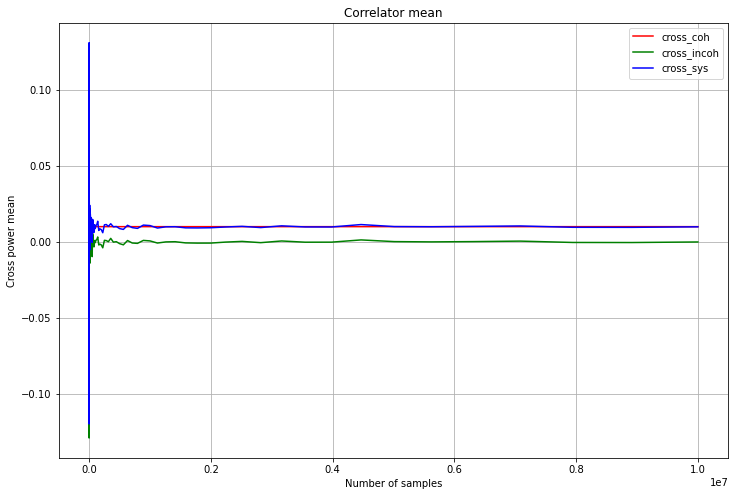

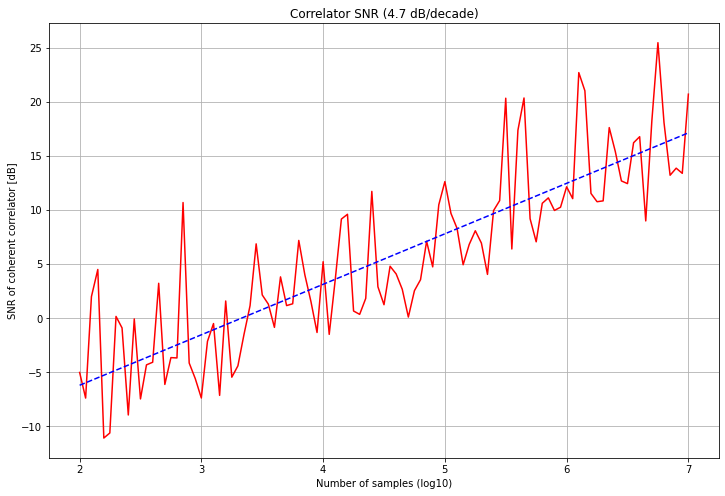

In [7]:
# Number of samples N_samples in time for input A and input B, try N_samples in N_samples_arr
N_steps = 100

N_min = 100
N_max = 10000000
n_incr = (N_max / N_min)**(1 / N_steps)
N_samples_arr = []
for s in range(N_steps + 1):
    n = int(N_min * n_incr**s)
    N_samples_arr.append(n)
N_samples_arr_log = np.log10(N_samples_arr)

# Input signal
sigma_coh = 0.1
pow_coh = sigma_coh**2
sigma_incoh = 1.0

input_SNR = (sigma_coh / sigma_incoh)**2
input_SNR_dB = 10 * np.log10(input_SNR)
print(f"SNR input = {input_SNR_dB:.3f} dB")

# Correlator mean(A * B)
cross_coh_mean_arr = []
cross_incoh_mean_arr = []
cross_sys_mean_arr = []
cross_SNR_arr = []
cross_SNR_dB_arr = []
for N_samples in N_samples_arr:
    si_coh = np.random.randn(N_samples)
    si_coh *= sigma_coh / np.std(si_coh)

    # Signal input A
    sA_incoh = np.random.randn(N_samples)
    sA_incoh *= sigma_incoh / np.std(sA_incoh)
    sA_sys = sA_incoh + si_coh

    # Signal input B
    sB_incoh = np.random.randn(N_samples)
    sB_incoh *= sigma_incoh / np.std(sB_incoh)
    sB_sys = sB_incoh + si_coh
    
    # Correlate A and B
    cross_coh_mean = np.mean(si_coh * si_coh)
    cross_coh_mean_arr.append(cross_coh_mean)
    cross_incoh_mean = np.mean(sA_incoh * sB_incoh)
    cross_incoh_mean_arr.append(cross_incoh_mean)
    cross_sys_mean = np.mean(sA_sys * sB_sys)
    cross_sys_mean_arr.append(cross_sys_mean)
    #print(f"{N_samples}, {cross_coh_mean:9.6f}, {cross_incoh_mean:9.6f}, {cross_sys_mean:9.6f}")

    # SNR of the coherent correlator.
    # * The SNR of the correlator improves with sqrt(N), so factor 10 = 10 dB when N increases by
    #   factor 100 = 20 dB.
    # * The cross_sys_mean is available from measured data, but the cross_coh_mean and
    #   cross_incoh_mean cannot be distinghuised in measured data, therefore the SNR can only be
    #   calculated in a model.
    # * Use select to try different SNR definitions. The SNR definitions are equivalent.
    select = 1
    # . using cross_coh_mean / cross_incoh_mean shows the cross_SNR improvement for all N_max
    if select == 1:
        cross_SNR = np.abs(cross_coh_mean / cross_incoh_mean)
    # . the cross_coh_mean and cross_sys_mean become pow_coh, so constant > 0. Therefor it is
    #   also possible to define relative cross_SNR using 1 divided by the value of cross_incoh_mean
    #   or the error in cross_coh_mean, which both go to zero.
    if select == 20:
        cross_SNR = np.abs(1 / cross_incoh_mean)
    if select == 21:
        cross_SNR = np.abs(1 / (cross_sys_mean - cross_coh_mean))    
    # . using cross_sys_mean requires that N_max > input_SNR to see the improvement in cross_SNR,
    #   because for lower N_samples the cross_sys_mean is still dominated by cross_incoh_mean and
    #   then thus cross_SNR = 1
    if select == 30:
        cross_SNR = np.abs(cross_sys_mean / cross_incoh_mean)
    if select == 31:
        cross_SNR = np.abs(cross_sys_mean / (cross_sys_mean - cross_coh_mean))

    cross_SNR_dB = 10 * np.log10(cross_SNR)
    cross_SNR_arr.append(cross_SNR)
    cross_SNR_dB_arr.append(cross_SNR_dB)
    #print(f"{N_samples}, correlator SNR = {cross_SNR_dB:.0f} dB")
    
plt.figure(figsize=(12, 8))
plt.plot(N_samples_arr, cross_coh_mean_arr, 'r', N_samples_arr, cross_incoh_mean_arr, 'g', N_samples_arr, cross_sys_mean_arr, 'b')
plt.title("Correlator mean")
plt.xlabel("Number of samples")
plt.ylabel("Cross power mean")
plt.legend(['cross_coh', 'cross_incoh', 'cross_sys'])
plt.grid()
plt.savefig('plots/signal_statistics_cross_correlator_mean.jpg', dpi=dpi)

plt.figure(figsize=(12, 8))
fit_coef = np.polyfit(N_samples_arr_log, cross_SNR_dB_arr, 1)
fit_p = np.poly1d(fit_coef)
fit_line = fit_p(N_samples_arr_log)
plt.plot(N_samples_arr_log, cross_SNR_dB_arr, 'r', N_samples_arr_log, fit_line, 'b--')
plt.title("Correlator SNR (%3.1f dB/decade)" % fit_p[1])
plt.xlabel("Number of samples (log10)")
plt.ylabel("SNR of coherent correlator [dB]")
plt.grid()
plt.savefig('plots/signal_statistics_cross_correlator_snr.jpg', dpi=dpi)

The expected cross correlation power is the power of the coherent input, because the other terms are uncorrelated and become zero:

E{(x+a)(y+a)} = E{xy} + E{xa} + E{ya} + E{a^2} = sigma_a^2 = var(a)

where:
* x = sA_incoh
* y = sB_incoh
* a = si_coh

The std of E{xy} is a measure of how close E{xy} is to zero. The var of E{xy} reduces with N_samples, so the std(E{xy}) reduces with sqrt(N_samples). Similar for E{xa} and E{ya}. The var(a) is constant and the std of E{xy} has the same (power) units as E{xy}, so therefore the 'coherent' SNR of the correlator depends on the accuracy of E{xy}, and therefore the 'coherent' SNR improves with sqrt(N_samples). This agrees with cross_SNR in the simulation.

Note that var(E{xy}) is not E{xyxy}.

**Conclusion:**
The expected coherent cross power of the cross correlator is pow_coh. The measurement of cross_coh_mean = pow_coh becomes more accurate when N_samples increases. The incoherent cross power is cross_incoh_mean and goes to zero. The cross power is a power statistics, but the two inputs are voltages so their phase information is preserved and therefore the correlator also has a 'coherent' SNR improvement. The 'coherent' SNR of the coherent correlator is proportional to 1 / cross_incoh_mean. Dividing by almost zero causes the 'coherent' SNR to fluctuate, but on average the 'coherent' SNR of the coherent signal improves by sqrt(N_samples), so by 5 dB / decade.